In [1]:
import seaborn as sns
from sklearn.metrics import classification_report, recall_score,precision_score , f1_score, accuracy_score
from sklearn import metrics
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd
import numpy as np
import json
from tabulate import tabulate
from tqdm import trange
import random
import seaborn as sns
from sklearn.metrics import classification_report, recall_score,precision_score , f1_score, accuracy_score
import sys
sys.path.append("HateRecognition/target_model/")
from utils import preprocessing, load_anno_data, data_loader, define_target, create_model
from bertopic import BERTopic
from TopicTuner.topictuner import TopicModelTuner as TMT
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from sklearn.model_selection import StratifiedKFold
from hdbscan import HDBSCAN
from sklearn.metrics import confusion_matrix
sys.path.append("../")
from TweetNormalizer import normalizeTweet
import gc
from cleantext import clean
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector

In [33]:
with_topic=True
file_name = "parler_target_annotated"
model_name = "hatexplain"
df = pd.read_csv(fr'../results/{file_name}_{model_name}_{str(with_topic)}.csv')
df

,Unnamed: 0.1,Unnamed: 0,index,id,text,label_mean,disputable_post,target,lang,topics,probs,pred,pred_labels
0,0,0,0,991dbab436b54d9b829df42f002748a1,"now the blacks not only want welfare , free co...",5,False,African,en,0_nigger_white_niggers_like,0.840711,African,0
1,1,1,1,2120be390d02480ba91a41c6cc99d621,listening to chuckie and pelosi aboyt isis ! i...,5,False,other,en,1_moslem_muslim_sand_number,1.000000,other,4
2,2,2,2,06105fc7f89c4488a585c5c2c6813e85,chuck schumer : oc / aeura ~ weoc / aeura ( tm...,5,False,African,en,1_moslem_muslim_sand_number,0.652393,other,4
3,3,3,3,de6c9ee12daf48c5b68d5be4572e18e9,"i hate muslims . i hate democrats , they are t...",5,False,Islam,en,1_moslem_muslim_sand_number,0.685604,Islam,2
4,4,4,4,10f9d6ff0aa045b9bb2e39d0d0e8afcb,her and the blm can go to hell they are a terr...,5,False,African,en,2_kike_jews_jew_white,0.890300,African,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,354,364,364,3a8d9b093ca241a78b4c11978bc4925b,"to all of the get what you can take , donoc / ...",5,False,other,en,1_moslem_muslim_sand_number,0.641758,other,4
355,355,365,365,04c69223f14d40658d1ccdcd11715548,blm is a palestinian terrorist organization . ...,5,False,Islam,en,0_nigger_white_niggers_like,0.861921,Islam,2
356,356,366,366,42f8558247e341379f820c3f875517e5,what is kamala a woman or a man ? she 's the c...,5,False,other,en,-1_user_nigger_number_white,0.000000,other,4
357,357,367,367,a2bd3d4710ab412a9beef2571b213d78,nothing name democrat ... should be allowed to...,5,False,other,en,1_moslem_muslim_sand_number,0.932756,other,4


In [34]:
g_hate_df = df.groupby(['target', 'pred']).count()['text'].reset_index()
# g_hate_df = res_df.groupby(['topics', 'pred']).count()['text'].reset_index()
p_g_hate_df = g_hate_df.pivot_table(columns=g_hate_df.target, index=g_hate_df.pred)
# p_g_hate_df = g_hate_df.pivot_table(columns=g_hate_df.topics, index=g_hate_df.pred)
p_g_hate_df.columns = p_g_hate_df.columns.droplevel(0)
# p_g_hate_df = p_g_hate_df.reindex(['other','African' ,'Islam', 'Jewish', 'Homosexual'])
n_p_g_hate_df = p_g_hate_df.apply(lambda x: x/x.sum(), axis=1)#.drop(columns=['-1_user_nigger_number_white'])

<AxesSubplot:xlabel='target', ylabel='pred'>

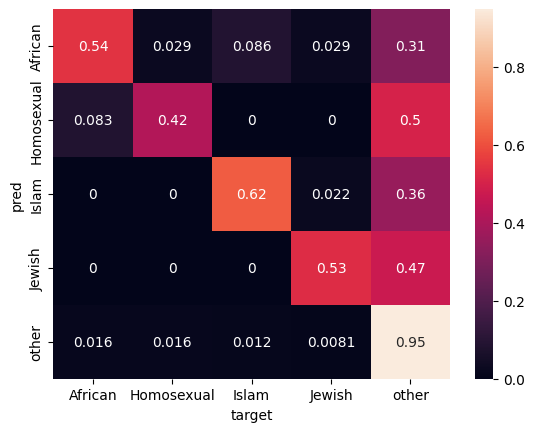

In [35]:
sns.heatmap(n_p_g_hate_df.fillna(0), annot=True)

In [36]:
true_labels = df.target
pred_labels = df.pred
accuracy = accuracy_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels, average='macro')
precision= precision_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')

In [37]:
print(f"accuracy:{accuracy}\nreacall:{recall}\nprecision:{precision}\nf1:{f1}")

accuracy:0.8272980501392758
reacall:0.735571448796125
precision:0.6111284932762013
f1:0.6617545423895992


In [101]:
print(metrics.classification_report(df.target, df.pred))

              precision    recall  f1-score   support

     African       0.30      0.46      0.36       152
  Homosexual       0.71      0.42      0.53       137
       Islam       0.39      0.38      0.38       112
      Jewish       0.62      0.57      0.59       130
       other       0.78      0.77      0.78      1077

    accuracy                           0.67      1608
   macro avg       0.56      0.52      0.53      1608
weighted avg       0.69      0.67      0.67      1608



In [94]:
view = df[df.index.isin(res_df[((df.target=='Politician')|(df.target=='other'))&(res_df.pred=='Islam')].index)]

NameError: name 'res_df' is not defined

In [95]:
view = res_df[(res_df['pred']!='other')&(res_df['topics']!='-1_user_nigger_number_white')&(res_df['label_mean']==5)]

NameError: name 'res_df' is not defined

In [16]:
false_df = pd.read_csv(fr'../results/{file_name}_{model_name}_{str(False)}.csv')


In [33]:
c_df = df.join(false_df, lsuffix="_first", rsuffix=("_second"))

In [68]:
winners = c_df[(c_df['pred_first']!=c_df['pred_second'])&(c_df['pred_first']!='other')&(c_df['pred_first']==c_df['target_first'])][['text_first','pred_first','pred_second','target_first','topics']]

In [69]:
print(winners.sample(10).to_markdown())

|        | text_first                                                                                                                                                 | pred_first   | pred_second   | target_first   | topics                       |
|-------:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------|:--------------|:---------------|:-----------------------------|
| 125198 | as a mtf trans person , i am sick of seeing the same story over and over about how i live my life ; show us something else                                 | Homosexual   | other         | Homosexual     | 3_faggots_faggot_user_queers |
| 126606 | my sexuality should be constantly scrutinized by everyone else                                                                                             | Homosexual   | other         | Homosexual     | 3_faggots_faggot_user_queers |
|  29579 | i

In [57]:
c_df.topics

0         0_nigger_white_niggers_like
1         0_nigger_white_niggers_like
2         -1_user_nigger_number_white
3         0_nigger_white_niggers_like
4         0_nigger_white_niggers_like
                     ...             
238483    -1_user_nigger_number_white
238484    0_nigger_white_niggers_like
238485          2_kike_jews_jew_white
238486    0_nigger_white_niggers_like
238487    -1_user_nigger_number_white
Name: topics, Length: 238488, dtype: object

In [65]:
winners.loc[41].text_first

,text_first,pred_first,pred_second,target_first,topics
14,"in order to be successful in the world , one m...",African,other,African,-1_user_nigger_number_white
19,the best way to get rid of a problem is to get...,African,other,African,0_nigger_white_niggers_like
20,"no matter what they do , no matter what they a...",African,other,African,0_nigger_white_niggers_like
41,the only way to get a good job is to be born w...,African,other,African,0_nigger_white_niggers_like
62,"if youre white , youre automatically better th...",African,other,African,0_nigger_white_niggers_like
...,...,...,...,...,...
198593,events for beginners and advanced learners . m...,Jewish,other,Jewish,2_kike_jews_jew_white
198603,justice has israel 's netanyahu seems to want ...,Jewish,Islam,Jewish,-1_user_nigger_number_white
198668,i also have heard a lot of comments that are t...,Jewish,Islam,Jewish,2_kike_jews_jew_white
198710,israelis can not be blamed for defending its b...,Jewish,Islam,Jewish,2_kike_jews_jew_white
